## Analysis of a particular $H_Q$

Imports

In [2]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
from cupyx.scipy.sparse.linalg import eigsh as eigsh_cp

file_name='data/cki'

SPS=SingleParticleState(file_name=file_name)



nparts=[(2,0)]
titles=[r'$^{18}$O']



size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

In [3]:
binding_energy=0.
# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])
from scipy.sparse import identity
#Quadrupole Operator
energy_errors=[]
fidelities=[]
for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    
    shifted_hamiltonian=NSMHamiltonian.hamiltonian+binding_energy*identity(n=NSMHamiltonian.hamiltonian.shape[0])


    egs,psi0=eigsh(shifted_hamiltonian,k=1,which='SA')


    print(egs)
    QPC=QuasiParticlesConverterOnlynnpp()

    QPC.initialize_shell(state_encoding=SPS.state_encoding)


    #just for the basis
    QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
    
    hamiltonian_qq=QPC.particles2quasiparticles @ shifted_hamiltonian @ QPC.particles2quasiparticles.T
    
    egs_qq,psi_q=eigsh(hamiltonian_qq,k=1,which='SA')
    
    psi_q=QPC.particles2quasiparticles.T @ psi_q[:,0]
    delta=np.abs((egs_qq[0]-egs[0])/egs[0])
    energy_errors.append(delta)
    
    fidelity=(psi_q[:].dot(psi0[:,0])).conjugate()*(psi_q[:].dot(psi0[:,0]))
    fidelities.append(1-fidelity.item())
    

size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.54it/s]
1424it [00:01, 1374.73it/s]


[-3.04879798]


In [4]:
print(hamiltonian_qq)

  (np.int32(0), np.int32(0))	1.5678999999999998
  (np.int32(0), np.int32(1))	1.0430999999999995
  (np.int32(0), np.int32(2))	-3.763858685577873
  (np.int32(1), np.int32(0))	1.0430999999999995
  (np.int32(1), np.int32(1))	1.5678999999999998
  (np.int32(1), np.int32(2))	3.763858685577873
  (np.int32(2), np.int32(0))	-3.763858685577873
  (np.int32(2), np.int32(1))	3.763858685577873
  (np.int32(2), np.int32(2))	4.8797


In [5]:
print(twobody_matrix[(0,3,1,2)],twobody_matrix[(0,3,2,1)])

1.0430999999999995 -1.0430999999999995


Analysis of the shift

In [6]:

energy_shift=np.linspace(0,10,1)
print(energy_shift)

for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()
energy_errors=[]
fidelities=[]
energies_qq=[]
spectrum=[]
for es in energy_shift:

    binding_energy=-es
    # Compute the J^2 value
    #J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])
    from scipy.sparse import identity
    #Quadrupole Operator



        
    shifted_hamiltonian=NSMHamiltonian.hamiltonian+binding_energy*identity(n=NSMHamiltonian.hamiltonian.shape[0])


    egs,psis=np.linalg.eigh(shifted_hamiltonian.todense())
    print(egs[0])

    QPC=QuasiParticlesConverterOnlynnpp()

    QPC.initialize_shell(state_encoding=SPS.state_encoding)


    #just for the basis
    QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
    
    hamiltonian_qq=QPC.particles2quasiparticles @ shifted_hamiltonian @ QPC.particles2quasiparticles.T
    print(hamiltonian_qq.todense())
    egs_qq,psi_q=eigsh(hamiltonian_qq,k=1,which='SA')
    print(egs_qq[0])
    psi_q=QPC.particles2quasiparticles.T @ psi_q[:,0]
    delta=np.abs((egs_qq[0]-egs[0])/egs[0])
    energy_errors.append(delta)
    fidelity=(np.einsum('i,ia->a',psi_q.conjugate(),psis)*np.conjugate(np.einsum('i,ia->a',psi_q.conjugate(),psis)))
    fidelities.append(fidelity)
    energies_qq.append(egs_qq)
    spectrum.append(egs)
    

fidelities=np.asarray(fidelities)
spectrum=np.asarray(spectrum)
energies_qq=np.asarray(energies_qq)
    

[0.]
size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  6.36it/s]
1424it [00:01, 1028.87it/s]


-3.0487979838460735
[[ 1.5679      1.0431     -3.76385869]
 [ 1.0431      1.5679      3.76385869]
 [-3.76385869  3.76385869  4.8797    ]]
-3.0487979838460735


(1, 5)


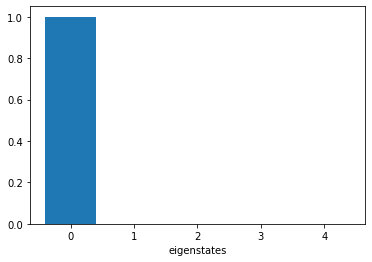

In [7]:
print(fidelities.shape)

plt.bar(x=np.arange(fidelities.shape[-1]),height=fidelities[0,:])
plt.xlabel('eigenstates')
plt.show()

#### The driver Hamiltonian $H_D$

initial state= [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
idx= 0
min energy= 1.5678999999999998
external field= [-0.78395 -0.      -0.      -0.78395 -0.      -0.      -0.      -0.
 -0.      -0.      -0.      -0.     ]
(3, 3) (3,) (3, 5)
-1.5678999999999998 [[0.]
 [0.]
 [0.]]


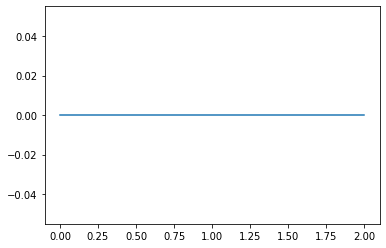

  (np.int32(0), np.int32(0))	-1.5678999999999998


In [8]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1



print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(shifted_hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

print('external field=',external_field)

e0,psis=InitialHamiltonian.get_spectrum(n_states=1)
psi_configuration=psis[:,0]

initialhamiltonianQQ=QPC.particles2quasiparticles @ InitialHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T

values,psis=np.linalg.eigh(initialhamiltonianQQ.todense())
print(psis.shape,values.shape,QPC.particles2quasiparticles.shape)

psi_configuration_qq=psis[:,0].copy()


print(values[0],((psis[:,0]-psi_configuration_qq)))
plt.plot(psis[:,0]-psi_configuration_qq)
plt.show()

print(initialhamiltonianQQ)

In [9]:
print(hamiltonian_qq.shape)

(3, 3)


Perform the quantum Annealing protocol in $H_Q$

In [10]:
time_step=150
tf=15
n_levels=3
dt=tf/time_step
energy=np.zeros(time_step)
time=np.linspace(0,tf,time_step)
spectrum=np.zeros((time_step,n_levels))
psi=np.asarray(psi_configuration_qq.copy())[:,0]

for i,t in enumerate(time):
    hamiltonian_t=(1-t/tf)*initialhamiltonianQQ+(t/tf)*hamiltonian_qq
    
    eiglevals,_=np.linalg.eigh(hamiltonian_t.todense())
    psi=expm_multiply(-1j*dt*hamiltonian_t,psi)
    energy[i]=psi[:].conjugate().dot(hamiltonian_t.dot(psi[:]))
    spectrum[i]=eiglevals

_,psigs=eigsh(hamiltonian_qq,k=1,which='SA')
fidelity=(psigs[:,0].conjugate().dot(psi))*np.conjugate((psigs[:,0].conjugate().dot(psi)))

print(fidelity)

(0.9813350752250924+0j)


/tmp/ipykernel_2362799/2357051598.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  energy[i]=psi[:].conjugate().dot(hamiltonian_t.dot(psi[:]))


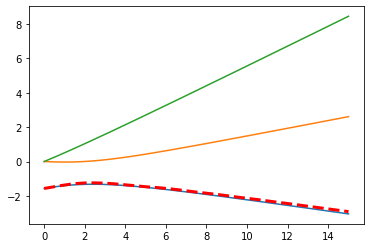

In [11]:
for i in range(n_levels):
    plt.plot(time,spectrum[:,i])
plt.plot(time,energy,linewidth=3,linestyle='--',color='red')
plt.show()


In [12]:
np.savez('data/quantum_annealing_pure_qa_6he',psi_exact=psigs,psi=psi,spectrum=spectrum,time=time,energy=energy,fidelity=fidelity)

## Analysis of $H_Q$ with respect to the exact ground state for the sd and pf shells

#### Imports

In [ ]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
from cupyx.scipy.sparse.linalg import eigsh as eigsh_cp

file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)



nparts=[(2,0),(4,0),(6,0),(8,0),(2,2),(4,2),(6,2),(8,2),(4,4),(6,4),(8,4),(6,6),(8,6),(10,6)]
titles=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O',r'$^{20}$Ne',r'$^{22}$Ne',r'$^{24}$Ne',r'$^{26}$Ne',r'$^{24}$Mg',r'$^{26}$Mg',r'$^{28}$Mg',r'$^{28}$Si',r'$^{30}$Si',r'$^{32}$Si']

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

In [ ]:
# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator
energy_errors=[]
fidelities=[]
for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    gpu_hamiltonian=cp_csr_matrix(NSMHamiltonian.hamiltonian)
    egs,psi0=eigsh_cp(gpu_hamiltonian,k=1,which='SA')

    print(egs)
    QPC=QuasiParticlesConverterOnlynnpp()

    QPC.initialize_shell(state_encoding=SPS.state_encoding)


    #just for the basis
    QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
    
    hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
    
    gpu_hamiltonian_qq=cp_csr_matrix(hamiltonian_qq)
    egs_qq,psi_q=eigsh_cp(gpu_hamiltonian_qq,k=1,which='SA')
    
    psi_q=QPC.particles2quasiparticles.T @ psi_q[:,0].get()
    delta=np.abs((egs_qq[0].get()-egs[0].get())/egs[0].get())
    energy_errors.append(delta)
    
    fidelity=(psi_q[:].dot(psi0[:,0].get())).conjugate()*(psi_q[:].dot(psi0[:,0].get()))
    fidelities.append(1-fidelity.item())
    

In [ ]:
fig,ax=plt.subplots(figsize=(20,10))
ax.bar(x=np.arange(len(titles)),height=energy_errors,width=0.3,label=r'$\Delta_Q E$')
ax_twin=ax.twinx()
ax_twin.bar(x=np.arange(len(titles))+0.3,height=fidelities,color='red',width=0.3,label=r'$1-F_Q$')
plt.xticks(np.arange(len(titles)),titles)
ax.legend(fontsize=20,loc='center left')
ax_twin.legend(fontsize=20,loc='upper left')
ax.tick_params(which='major',labelsize=20)
ax_twin.tick_params(which='major',labelsize=20)
ax.set_ylabel(r'$\Delta_Q E$',fontsize=30)
ax_twin.set_ylabel(r'$1-F_Q$',fontsize=30)

plt.show()

In [ ]:
# Dummy data (replace with your real energy_errors or fidelities)
values = energy_errors  # Or use energy_errors or fidelities

# Get all even values for proton/neutron
protons = sorted(set(p for n, p in nparts))
neutrons = sorted(set(n for n, p in nparts))

# Create mapping from proton/neutron count to index
p_idx = {p: i for i, p in enumerate(protons)}
n_idx = {n: i for i, n in enumerate(neutrons)}

# Create matrix
matrix = np.full((len(neutrons), len(protons)), np.nan)  # NaN for no data

# Fill matrix with values at valid (n, p)
for (n, p), val in zip(nparts, values):
    matrix[n_idx[n], p_idx[p]] = val

# Plotting
fig, ax = plt.subplots(2,1,figsize=(10, 20))
cax = ax[0].imshow(matrix, cmap='viridis', origin='lower')

# Axis ticks and labels
ax[0].set_xticks(np.arange(len(protons)))
ax[0].set_yticks(np.arange(len(neutrons)))
ax[0].set_xticklabels(protons, fontsize=14)
ax[0].set_yticklabels(neutrons, fontsize=14)
ax[0].set_xlabel(r"$Z_p$", fontsize=30)
ax[0].set_ylabel(r"$N_n$", fontsize=30)

# Overlay values and names
for (n, p), title, val in zip(nparts, titles, values):
    i = n_idx[n]
    j = p_idx[p]
    if not np.isnan(val):
        ax[0].text(j, i - 0.2, f"{title}", ha='center', va='center', color='white', fontsize=20, weight='bold')
        ax[0].text(j, i + 0.3, f"{val:.2f}", ha='center', va='center', color='white', fontsize=20)

# Add colorbar
cbar = fig.colorbar(cax, ax=ax[0])
cbar.set_label(r'$\Delta_Q E$', fontsize=30)
ax[0].set_title(r'$\Delta_Q E$',fontsize=30)
cbar.ax.tick_params(labelsize=20)
values = fidelities  # Or use energy_errors or fidelities

# Get all even values for proton/neutron
protons = sorted(set(p for n, p in nparts))
neutrons = sorted(set(n for n, p in nparts))

# Create mapping from proton/neutron count to index
p_idx = {p: i for i, p in enumerate(protons)}
n_idx = {n: i for i, n in enumerate(neutrons)}

# Create matrix
matrix = np.full((len(neutrons), len(protons)), np.nan)  # NaN for no data

# Fill matrix with values at valid (n, p)
for (n, p), val in zip(nparts, values):
    matrix[n_idx[n], p_idx[p]] = val

# Plotting

cax = ax[1].imshow(matrix, cmap='viridis', origin='lower')

# Axis ticks and labels
ax[1].set_xticks(np.arange(len(protons)))
ax[1].set_yticks(np.arange(len(neutrons)))
ax[1].set_xticklabels(protons, fontsize=14)
ax[1].set_yticklabels(neutrons, fontsize=14)
ax[1].set_xlabel(r"$Z_p$", fontsize=30)
ax[1].set_ylabel(r"$N_n$", fontsize=30)

# Overlay values and names
for (n, p), title, val in zip(nparts, titles, values):
    i = n_idx[n]
    j = p_idx[p]
    if not np.isnan(val):
        ax[1].text(j, i - 0.2, f"{title}", ha='center', va='center', color='white', fontsize=20, weight='bold')
        ax[1].text(j, i + 0.3, f"{val:.2f}", ha='center', va='center', color='white', fontsize=20)
ax[1].set_title(r'$1-F_Q$',fontsize=30)
# Add colorbar
cbar = fig.colorbar(cax, ax=ax[1])
cbar.set_label(r'$1-F_Q$', fontsize=30)
cbar.ax.tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20)
plt.tight_layout()
plt.show()

### Pf Shell Case

#### Imports

In [ ]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
from cupyx.scipy.sparse.linalg import eigsh as eigsh_cp

file_name='data/gxpf1a'

SPS=SingleParticleState(file_name=file_name)



nparts=[(2,0),(4,0),(6,0),(8,0),(10,0),(2,2)]
titles=[r'$^{42}$Ca',r'$^{44}$Ca',r'$^{46}$Ca',r'$^{48}$Ca',r'$^{50}$Ca',r'$^{44}$Ti']

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

In [ ]:
# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator
energy_errors=[]
fidelities=[]
for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/gxpf1a_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    gpu_hamiltonian=cp_csr_matrix(NSMHamiltonian.hamiltonian)
    egs,psi0=eigsh_cp(gpu_hamiltonian,k=1,which='SA')

    print(egs)
    QPC=QuasiParticlesConverterOnlynnpp()

    QPC.initialize_shell(state_encoding=SPS.state_encoding)


    #just for the basis
    QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
    
    hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
    
    gpu_hamiltonian_qq=cp_csr_matrix(hamiltonian_qq)
    egs_qq,psi_q=eigsh_cp(gpu_hamiltonian_qq,k=1,which='SA')
    
    psi_q=QPC.particles2quasiparticles.T @ psi_q[:,0].get()
    delta=np.abs((egs_qq[0].get()-egs[0].get())/egs[0].get())
    energy_errors.append(delta)
    
    fidelity=(psi_q[:].dot(psi0[:,0].get())).conjugate()*(psi_q[:].dot(psi0[:,0].get()))
    fidelities.append(1-fidelity.item())
    

In [ ]:
# Assuming energy_errors, fidelities, titles are already defined
fig, ax = plt.subplots(figsize=(10, 20))  # Swap width and height

y_pos = np.arange(len(titles))

# Main horizontal bars
ax.barh(y=y_pos, width=energy_errors, height=0.3, label=r'$\Delta_Q E$')

# Twin axis for the second set of bars
ax_twin = ax.twiny()
ax_twin.barh(y=y_pos + 0.3, width=fidelities, height=0.3, color='red', label=r'$1-F_Q$')

# Set y-ticks to titles
plt.yticks(y_pos, titles)

# Legends
ax.legend(fontsize=30,loc='lower right' )
ax_twin.legend(fontsize=30, loc='center right')

# Tick and label formatting
ax.tick_params(which='major', labelsize=20)
ax_twin.tick_params(which='major', labelsize=20)
ax.set_xlabel(r'$\Delta_Q E$', fontsize=30)
ax_twin.set_xlabel(r'$1-F_Q$', fontsize=30)

plt.tight_layout()
plt.show()

## Analysis of $H_{eff}$

In [163]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=10
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title='28Ne'


In [164]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)


size= 24 12


FileNotFoundError: [Errno 2] No such file or directory: 'data/nuclear_twobody_matrix/usdb_10_2.npz'

In [154]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T

#j2_qq=QPC.particles2quasiparticles @ J2Class.hamiltonian @ QPC.particles2quasiparticles.T

values,psi_qq=eigsh(hamiltonian_qq,k=1,which='SA')

#### Effective Hamiltonian results

In [155]:
data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_'+title+'.npz',allow_pickle=True)

psis=data['psi']
energies=data['energy']
final_hamiltonian=data['final_effective_hamiltonian']


In [ ]:

print(psis[-1].conjugate().dot(j2_qq.dot(psis[-1])))

In [ ]:
effective_final_psi=QPC.particles2quasiparticles.T @ psis[-1][:]
psi_qq_in_the_full_basis=QPC.particles2quasiparticles.T @ psi_qq[:,0]

In [ ]:
print(effective_final_psi.shape,psi0.shape)

In [ ]:
print(J2Class.j_value(psi=effective_final_psi))

In [ ]:
print((effective_final_psi.dot(psi0[:,0])*np.conjugate(effective_final_psi.dot(psi0[:,0]))))

In [144]:
data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_20O.npz',allow_pickle=True)
errors_o20=data['errors']
title_o20=data['title']

data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_20Ne.npz',allow_pickle=True)
errors_ne20=data['errors']
title_ne20=data['title']

data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_24Mg.npz',allow_pickle=True)
errors_mg24=data['errors']
title_mg24=data['title']

data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_28Si.npz',allow_pickle=True)
errors_si28=data['errors']
title_si28=data['title']


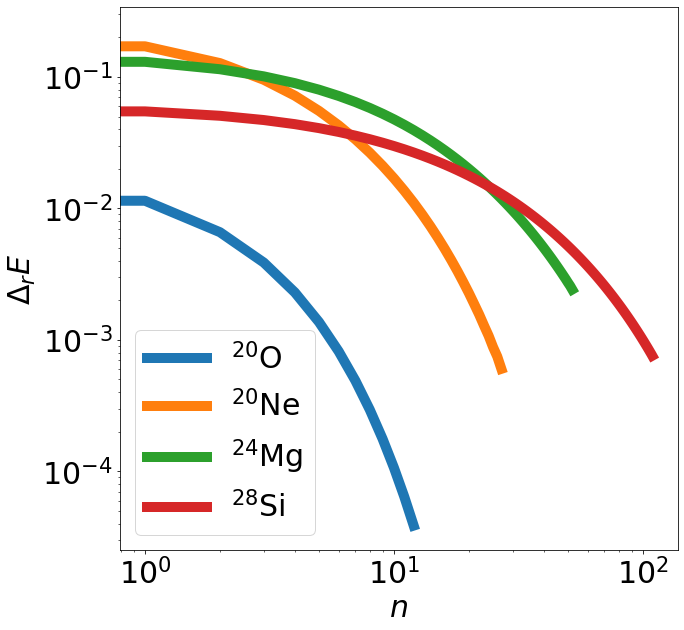

In [145]:
plt.figure(figsize=(10,10))
plt.plot(errors_o20,label=title_o20,linewidth=10)
plt.plot(errors_ne20,label=title_ne20,linewidth=10)
plt.plot(errors_mg24,label=title_mg24,linewidth=10)
plt.plot(errors_si28,label=title_si28,linewidth=10)
plt.loglog()
plt.tick_params(labelsize=30)
plt.xlabel(r'$n$',fontsize=30)
plt.ylabel(r'$\Delta_r E$',fontsize=30)
plt.legend(fontsize=30)
plt.show()

#### Load the two-body matrix elements (only neutrons)

In [156]:
n_qubits=6
neutron_denominator=nparticles_a//2
proton_denominator=nparticles_b//2
print(neutron_denominator,proton_denominator)

data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_sd.npz')
keys=data_onebody['keys']
values=data_onebody['values']

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[tuple(key)]=values[a]
    if i==j:
        print(values[a])
print(t_onebody)

data_twobody=np.load('data/matrix_elements_h_eff_2body/twobody_nn_sd.npz')
keys=data_twobody['keys']
values=data_twobody['values']
t_twobody={}
for a,key in enumerate(keys):
    key
    t_twobody[tuple(key)]=values[a]
print(t_twobody)


data_twobody_correction=np.load('data/matrix_elements_h_eff_2body/twobody_nn_correction_sd.npz')
keys=data_twobody_correction['keys']
values=data_twobody_correction['values']
t_twobody_correction={}
for a,key in enumerate(keys):
    key
    t_twobody_correction[tuple(key)]=values[a]
print(t_twobody_correction)

4 1
-9.3151
-8.8615
-9.145
-8.107099999999999
3.2251000000000003
3.2251000000000003
{(np.int64(0), np.int64(0)): np.float64(-9.3151), (np.int64(0), np.int64(1)): np.float64(0.6897999999999996), (np.int64(0), np.int64(2)): np.float64(-0.4062999999999996), (np.int64(0), np.int64(3)): np.float64(-0.900781889989654), (np.int64(0), np.int64(4)): np.float64(-1.9314456782406446), (np.int64(0), np.int64(5)): np.float64(0.6017349640876247), (np.int64(1), np.int64(0)): np.float64(0.6897999999999996), (np.int64(1), np.int64(1)): np.float64(-8.8615), (np.int64(1), np.int64(2)): np.float64(0.8598999999999998), (np.int64(1), np.int64(3)): np.float64(0.900781889989654), (np.int64(1), np.int64(4)): np.float64(1.1336192497488327), (np.int64(1), np.int64(5)): np.float64(-1.3995613925794368), (np.int64(2), np.int64(0)): np.float64(-0.4062999999999996), (np.int64(2), np.int64(1)): np.float64(0.8598999999999998), (np.int64(2), np.int64(2)): np.float64(-9.145), (np.int64(2), np.int64(3)): np.float64(-0.9007

Add the protons

In [157]:


data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_pp_sd.npz')
keys=data_onebody['keys']
values=data_onebody['values']

t_onebody_pp={}

for a,key in enumerate(keys):
    t_onebody_pp[tuple(key)]=values[a]

print(t_onebody_pp)

data_twobody=np.load('data/matrix_elements_h_eff_2body/twobody_pp_sd.npz')
keys=data_twobody['keys']
values=data_twobody['values']
t_twobody_pp={}
for a,key in enumerate(keys):

    t_twobody_pp[tuple(key)]=values[a]



data_twobody=np.load('data/matrix_elements_h_eff_2body/twobody_np_sd.npz')
keys=data_twobody['keys']
values=data_twobody['values']
t_twobody_np={}
for a,key in enumerate(keys):

    t_twobody_np[tuple(key)]=values[a]


data_twobody_correction=np.load('data/matrix_elements_h_eff_2body/twobody_pp_correction_sd.npz')
keys=data_twobody_correction['keys']
values=data_twobody_correction['values']
t_twobody_correction_pp={}
for a,key in enumerate(keys):
    t_twobody_correction_pp[tuple(key)]=values[a]

data_twobody_correction=np.load('data/matrix_elements_h_eff_2body/twobody_np_correction_sd.npz')
keys=data_twobody_correction['keys']
values=data_twobody_correction['values']
t_twobody_correction_np={}
for a,key in enumerate(keys):
    key
    t_twobody_correction_np[tuple(key)]=values[a]



{(np.int64(6), np.int64(6)): np.float64(-9.3151), (np.int64(6), np.int64(7)): np.float64(0.6897999999999995), (np.int64(6), np.int64(8)): np.float64(-0.4062999999999996), (np.int64(6), np.int64(9)): np.float64(-0.9007818899896537), (np.int64(6), np.int64(10)): np.float64(-1.9314456782406437), (np.int64(6), np.int64(11)): np.float64(0.6017349640876244), (np.int64(7), np.int64(6)): np.float64(0.6897999999999995), (np.int64(7), np.int64(7)): np.float64(-8.8615), (np.int64(7), np.int64(8)): np.float64(0.8598999999999996), (np.int64(7), np.int64(9)): np.float64(0.9007818899896537), (np.int64(7), np.int64(10)): np.float64(1.133619249748832), (np.int64(7), np.int64(11)): np.float64(-1.3995613925794361), (np.int64(8), np.int64(6)): np.float64(-0.4062999999999996), (np.int64(8), np.int64(7)): np.float64(0.8598999999999996), (np.int64(8), np.int64(8)): np.float64(-9.145), (np.int64(8), np.int64(9)): np.float64(-0.9007818899896537), (np.int64(8), np.int64(10)): np.float64(-0.7347060355029265), (n

Build up the twobody Hamiltonian

In [158]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)



hamiltonian_2body=0.
count=0.
for key,value in t_onebody.items():
    idx_a,idx_b=key
    hamiltonian_2body+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)


if neutron_denominator!=1:
    for key,value in t_twobody.items():
        idx_a,idx_b,idx_c,idx_d=key
        hamiltonian_2body+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    for key,value in t_twobody_correction.items():
        idx_a,idx_b,idx_c,idx_d=key
        hamiltonian_2body+=(value/(neutron_denominator*(neutron_denominator-1)/2))*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)


Only if protons

In [159]:
for key,value in t_onebody_pp.items():
    idx_a,idx_b=key
    hamiltonian_2body+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

for key,value in t_twobody_np.items():
    idx_a,idx_b,idx_c,idx_d=key
    hamiltonian_2body+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
if proton_denominator!=1:
    for key,value in t_twobody_pp.items():
        idx_a,idx_b,idx_c,idx_d=key
        hamiltonian_2body+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    for key,value in t_twobody_correction_pp.items():
        idx_a,idx_b,idx_c,idx_d=key
        hamiltonian_2body+=(value/(proton_denominator*(proton_denominator-1)/2))*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
for key,value in t_twobody_correction_np.items():
    idx_a,idx_b,idx_c,idx_d=key
    hamiltonian_2body+=(value/(proton_denominator*neutron_denominator))*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)


In [160]:
print(hamiltonian_2body)


  (0, 0)	-81.92890841341249
  (0, 1)	1.0307923784915025
  (0, 2)	-0.6366156759482148
  (0, 3)	-1.447077045051502
  (0, 4)	-2.4960294355329333
  (0, 5)	0.8030005910059025
  (0, 6)	-0.8881133540321865
  (0, 7)	0.05079850039687484
  (0, 8)	-0.04604917952497183
  (0, 9)	-0.18391639411170896
  (0, 10)	-0.04816908059357153
  (0, 11)	0.020165022895540823
  (0, 12)	0.75765576195682
  (0, 13)	-0.017048939842963108
  (0, 14)	-0.0012019464201395093
  (0, 15)	0.01976442175654416
  (0, 16)	0.01584261235154752
  (0, 17)	-0.0003251269375714308
  (0, 18)	-0.8742308491445164
  (0, 19)	0.05579778518258801
  (0, 20)	-0.07331326436733432
  (0, 21)	-0.049104475352873024
  (0, 22)	-0.03893102222956186
  (0, 23)	0.03884917657471342
  (0, 24)	1.8443459277092655
  (0, 25)	-0.009161626867068723
  (0, 26)	0.007371723644009713
  (0, 27)	-0.00292195453813838
  (0, 28)	0.013829733048441595
  (0, 29)	-0.00475602365027327
  (0, 30)	0.0013402510085028672
  (0, 36)	1.3415378070160489
  (0, 37)	-0.06014409689988474
  (0

In [161]:
egs_2body,psi_2body=eigsh(hamiltonian_2body,k=1,which='SA')

egs_2body=egs_2body[0]
psi_2body=psi_2body[:,0]

print(egs_2body,egs,energies[0])

-88.3789671052502 [-87.14199175] -83.39207900030142


In [162]:
print(egs)

print('energy relative error=',(egs_2body-egs)/np.abs(energies[-1]))
print('1-fidelity=',1-psi_2body.conjugate().dot(psis[-1])*np.conjugate(psi_2body.conjugate().dot(psis[-1])))


[-87.14199175]
energy relative error= [-0.01419661]
1-fidelity= 0.01259372653568136


#### Plot the results of the 2body correction to the O and Ne isotopes

In [178]:
titles=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O',r'$^{20}$Ne',r'$^{22}$Ne',r'$^{24}$Ne',r'$^{26}$Ne']
fidelities=[10**-16,10**-9,1.3*10**-3,3.1*10**-4,2*10**-7,1.4*10**-2,9*10**-3,0.012]
energy_errors=[10**-16,10**-9,-1*10**-4,-5*10**-3,4*10**-4,2*10**-2,1.3*10**-3,-0.014]
#### values computed above



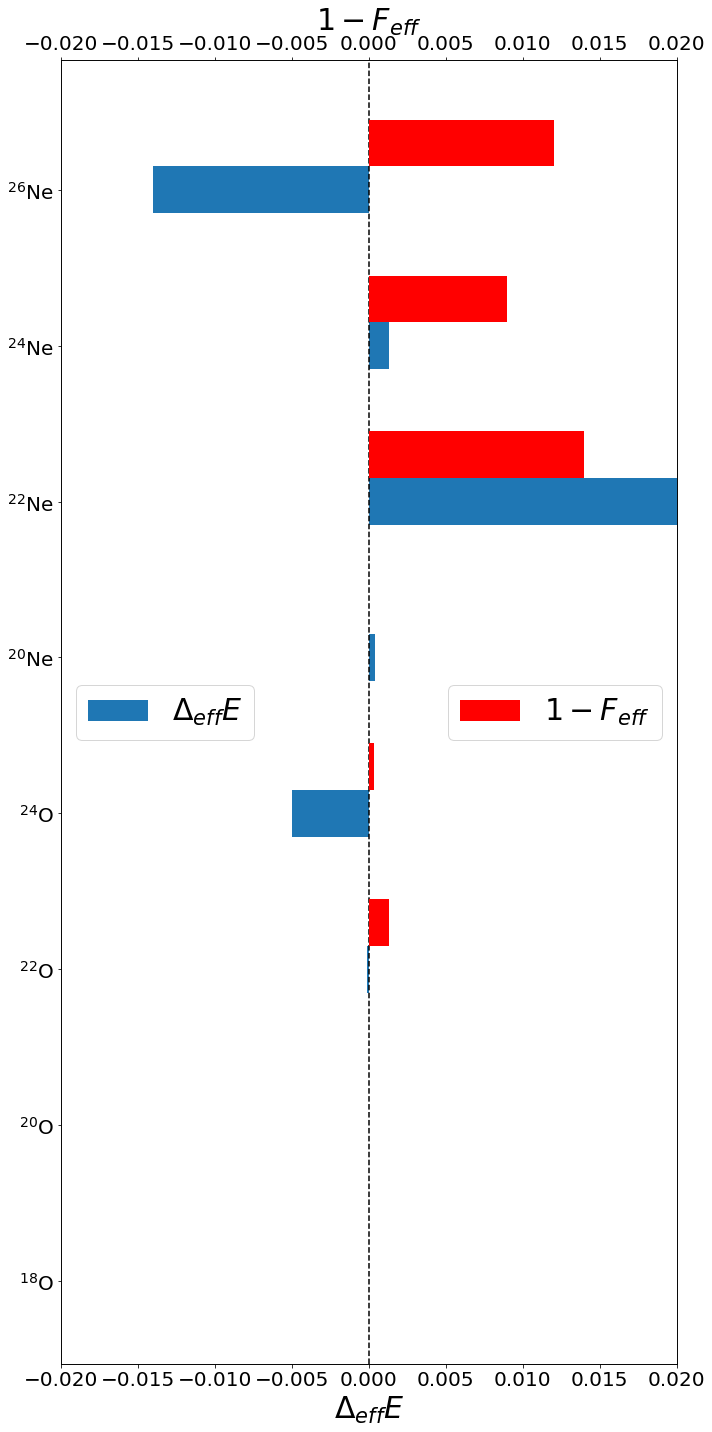

In [179]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming energy_errors, fidelities, titles are already defined
fig, ax = plt.subplots(figsize=(10, 20))  # Swap width and height

y_pos = np.arange(len(titles))

# Main horizontal bars
ax.barh(y=y_pos, width=energy_errors, height=0.3, label=r'$\Delta_{eff} E$')

# Twin axis for the second set of bars
ax_twin = ax.twiny()
ax_twin.barh(y=y_pos + 0.3, width=fidelities, height=0.3, color='red', label=r'$1-F_{eff}$')

# Set y-ticks to titles
plt.yticks(y_pos, titles)

# Determine common x-limits centered on zero
max_val = max(
    abs(np.min(energy_errors)), abs(np.max(energy_errors)),
    abs(np.min(fidelities)), abs(np.max(fidelities))
)
shared_xlim = (-max_val, max_val)

# Set same limits to both axes
ax.set_xlim(shared_xlim)
ax_twin.set_xlim(shared_xlim)

# Draw vertical zero line
ax.axvline(x=0., linestyle='--', color='black')

# Legends
ax.legend(fontsize=30, loc='center left')
ax_twin.legend(fontsize=30, loc='center right')

# Tick and label formatting
ax.tick_params(which='major', labelsize=20)
ax_twin.tick_params(which='major', labelsize=20)
ax.set_xlabel(r'$\Delta_{eff} E$', fontsize=30)
ax_twin.set_xlabel(r'$1-F_{eff}$', fontsize=30)

plt.tight_layout()
plt.show()

In [180]:
titles=[r'$^{42}$Ca',r'$^{44}$Ca',r'$^{46}$Ca',r'$^{48}$Ca',r'$^{50}$Ca']
fidelities=[0,7.6*10**-10,10**-4,2*10**-4,3*10**-4]
energy_errors=[0,4*10**-6,8*10**-4,-10**-3,-3*10**-4]



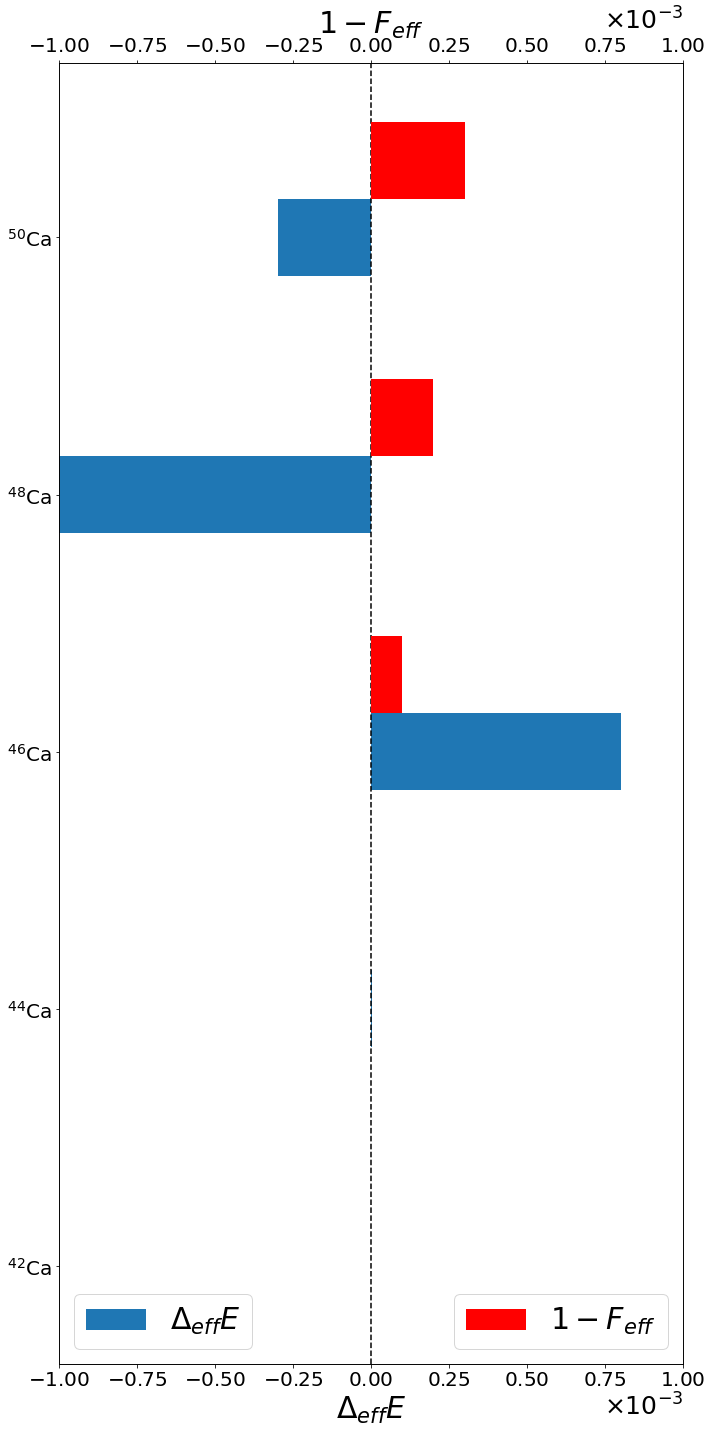

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter  # ADD THIS

# Assuming energy_errors, fidelities, titles are already defined
fig, ax = plt.subplots(figsize=(10, 20))

y_pos = np.arange(len(titles))

ax.barh(y=y_pos, width=energy_errors, height=0.3, label=r'$\Delta_{eff} E$')
ax_twin = ax.twiny()
ax_twin.barh(y=y_pos + 0.3, width=fidelities, height=0.3, color='red', label=r'$1-F_{eff}$')

plt.yticks(y_pos, titles)

max_val = max(
    abs(np.min(energy_errors)), abs(np.max(energy_errors)),
    abs(np.min(fidelities)), abs(np.max(fidelities))
)
shared_xlim = (-max_val, max_val)
ax.set_xlim(shared_xlim)
ax_twin.set_xlim(shared_xlim)

ax.axvline(x=0., linestyle='--', color='black')

ax.legend(fontsize=30, loc='lower left')
ax_twin.legend(fontsize=30, loc='lower right')

ax.tick_params(which='major', labelsize=20)
ax_twin.tick_params(which='major', labelsize=20)
ax.set_xlabel(r'$\Delta_{eff} E$', fontsize=30)
ax_twin.set_xlabel(r'$1-F_{eff}$', fontsize=30)

# FORMATTER FOR SCIENTIFIC NOTATION
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))

ax.xaxis.set_major_formatter(formatter)
ax_twin.xaxis.set_major_formatter(formatter)
ax.xaxis.offsetText.set_fontsize(25)
ax_twin.xaxis.offsetText.set_fontsize(25)

plt.tight_layout()
plt.show()